# Optimal Water Distribution in the City of Barcelona

David Feijóo Rodríguez, Joel Jurado Díaz, Alexandre Olivé Pellicer, Santiago Pérez Pérez

### Introduction 

The ABDataChallenge from Aigües de Barcelona is an open development challenge focused on innovation and problem-solving using prior knowledge of data and programming. By utilizing data from Aigües de Barcelona's Telelectura service and combining it with external data, the challenge seeks solutions related to topics such as Sustainability and Climate Change or Smart Cities.


### Motivation 
Our generation is a conscious one. We are aware that today there is a serious problem of water scarcity in many regions of the world. We recognize that water wastage, caused by losses in distribution infrastructure and inefficient water use in the agricultural and urban sectors, is a significant issue. The contamination of water sources by chemicals and waste discharge affects its quality. And if that weren't enough, variations in consumption and the need for infrastructure that serves everyone make this an incredibly complex problem.

Having identified the main issues and recognizing them as systemic problems, we have gone through a process of challenge definition, ideation, prototyping, and testing to find a systemic solution that can serve as a foundation to tackle these challenges.

For this reason, we have designed the implementation of a solution to predict water consumption and optimize distribution from the Water Treatment Stations (WTS) to each of the census sections.

### Goal
Our objective has been to develop the MVP of a tool that models and optimizes water distribution. To achieve this, we have planned the following. First, to predict the consumption expected for the next day using consumption data. Second, we have modeled the cost of each path from a Water Treatment Station (WTS) to each census section, taking into account various factors such as distance and height differences. Based on these costs, we wanted to implement one of the most advanced optimization techniques, Particle Swarm Optimization (PSO), which, together with consumption predictions and considering constraints like the capacities of each WTS, calculates the most optimal distribution. Finally, we wanted to conclude with an interactive part that allows visualization of the obtained results overlaid on a map of Barcelona.


### Datasets
The first dataset from Telelectura (dataset1_v2.csv) includes 8 columns indicating:
Census Section | District | Postal Code | Municipality | Date | Use | Number of meters | Accumulated consumption (L/day)

We are provided with 4 years of data collected daily, with variations in the number of meters collecting data from each census section. The use of meters allows us to distinguish between Domestic, Industrial, and Commercial, enabling more precise data grouping.


### Time series Processing
A time series is a succession of chronologically ordered values spaced at intervals, which may or may not be equidistant. First, we familiarized ourselves with their functioning since we did not have much knowledge about them. We learned about models like ARIMA, LSTMs, Prophet, DeepAR, and LightGBM, and how they function for time series prediction. The first thing we did was select the data and establish the interval with which we would work.


### Structure
The code consists of three main parts:

1. Prediction of the next day's consumption for each census section
2. Optimization of water distribution: Particle Swarm Optimization
3. Visualization tool

### Necessary information
The libraries used in the project are available in the attached file "ABDataChallenge.yml".

The expected average time for executing the notebook is 4 hours.


##  Variables & Imports


In [1]:
from datetime import datetime, timedelta
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from gluonts.dataset.pandas import PandasDataset
from gluonts.torch.model.deepar import DeepAREstimator
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import math
import geopandas as gpd
from shapely import Polygon, wkt, Point, LineString, MultiPoint
from shapely.wkt import loads
import folium
from itertools import product
import requests
from geopy.geocoders import Nominatim
from geopy import distance


/home/aolivepe/miniconda3/envs/ABDataChallenge/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/aolivepe/miniconda3/envs/ABDataChallenge/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1 : Predictor
The objective of the project is to determine the most efficient management of water within the Aigües de Barcelona distribution network for future days. Before deciding on the routes for water supply and the sources from which to obtain the water that will be supplied to different consumption points, it is necessary to predict what the consumption will be. To achieve this, we have used a model that predicts daily water consumption per census section.


## 1.1 Data pre-processing
A model capable of predicting future water consumption has been created. The dataset1_v2 provided by the ABDataChallenge was used to train it. This dataset contains: Census Section | District | Postal Code | Municipality | Date | Use | Number of meters | Accumulated consumption (L/day).

In our case, we are interested in having the daily consumption per census section. Therefore, we aggregated all the consumption per day by census section without considering other factors.

One of the issues with dataset1_v2 was that there were certain days for which there was no consumption record. To solve this problem, we performed an interpolation of the consumption from the previous day and the following day.

Additionally, we applied clipping to remove outliers in the water consumption data. We do this to eliminate atypical consumption values, as they can distort the training of the predictive model.


In [27]:
df = pd.read_csv('data/dataset1_v2.csv')
df = df.dropna(subset=['Secció Censal/Sección censal/Census section'], axis=0)
array_sec_cens = np.unique(np.array(df['Secció Censal/Sección censal/Census section']))

In [ ]:
df = pd.read_csv('data/dataset1_v2.csv')
df = df.dropna(subset=['Secció Censal/Sección censal/Census section'], axis=0)

id =[]
consum = []
temps = []
comptadors = []
i = 0

t1 = datetime.now()
print(t1)
for seccio in tqdm(np.unique(np.array(df['Secció Censal/Sección censal/Census section']))):
    aux = df[df['Secció Censal/Sección censal/Census section'] == seccio]
    
    dates = np.unique(aux['Data/Fecha/Date'])
    
    id_aux = []
    temps_aux = []
    consum_aux_l = []
    comptadors_aux_l = []
    for data in dates:
        consum_aux = aux[aux['Data/Fecha/Date'] == data]["Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)"]
        consum_aux = np.array(consum_aux).sum() 
        comptadors_aux = aux[aux['Data/Fecha/Date'] == data]["Nombre de comptadors/Número de contadores/Number of meters"]
        comptadors_aux = comptadors_aux.sum()
        t = datetime.strptime(data, "%Y-%m-%d")
        id_aux.append(i)
        temps_aux.append(t)
        consum_aux_l.append(consum_aux)
        comptadors_aux_l.append(comptadors_aux)

    mean = np.mean(consum_aux_l)
    std = np.std(consum_aux_l)
    consum_aux_l = np.clip(consum_aux_l, 0, mean + 3*std)

    difference = np.diff(temps_aux)
    id_aux = np.array(id_aux)
    temps_aux = np.array(temps_aux)
    consum_aux_l = np.array(consum_aux_l)
    comptadors_aux_l = np.array(comptadors_aux_l)
    while (difference > np.timedelta64(1, 'D')).any():
        mask = np.where(difference>np.timedelta64(1, 'D'))
        temps_aux = np.insert(temps_aux, mask[0] + 1,temps_aux[mask[0]] + timedelta(days=1))
        consum_aux_l = np.insert(consum_aux_l, mask[0] + 1, (consum_aux_l[mask[0]] + consum_aux_l[mask[0]+1])/2)
        comptadors_aux_l = np.insert(comptadors_aux_l, mask[0] + 1, (comptadors_aux_l[mask[0]] + comptadors_aux_l[mask[0]+1])/2)
        id_aux = np.insert(id_aux, mask[0] + 1,id_aux[mask[0]])
        difference = np.diff(temps_aux)
    i = i + 1
    id.extend(list(id_aux))
    consum.extend(list(consum_aux_l))
    temps.extend(list(temps_aux))
    comptadors.extend(list(comptadors_aux_l))
t2 = datetime.now()
print(t2-t1)
data = {'id': id, 'consum': consum, 'temps': temps, 'comptadors': comptadors}
new_df = pd.DataFrame(data)

Before training the predictor, we performed additional data preprocessing, which we called Data Cleaning.

Analyzing the data available for training, we noticed that over the four years of recorded water consumption, certain meters would stop functioning for periods ranging from 7 to 30 days. During these periods, the total recorded water consumption was reduced. It is most likely that the meters at certain consumption points stopped working, even though water consumption continued. For this reason, in order to use the most accurate training data possible and not be affected by the malfunctioning of certain meters, we decided to approximate what the actual water consumption might have been during the periods when the meters were not working.

To solve this problem, we considered that the best solution was to apply an offset to the water consumption during the periods when a certain number of meters were not functioning. This adjustment ensured that, subsequently, the consumption levels were similar to those during periods when all meters were operational.

Below is an image showing how data cleaning modifies the water consumption of a census section over time:
<p align="center">
  <img src="Datacleaning.png"  alt="Descripción de la imagen 2" width="80%"><br>
  <em></em>
</p>

In [8]:
final_consumo_suavizado_array = []
new_consum = []
window = 30
umbral = 200
for id in tqdm(np.unique(np.array(new_df['id']))):
    consumo_suavizado_array = []

    previous_cont = new_df[new_df['id'] == id].iloc[0]['comptadors']
    previous_cons = new_df[new_df['id'] == id].iloc[0]['consum']
    for index, row in new_df[new_df['id'] == id].iterrows():
        if previous_cont - row['comptadors'] > umbral:
            if consumo_suavizado_array[-1] == previous_cons:
                diff = previous_cons - row['consum']-1
            consumo_suavizado = row['consum']+diff
            
            consumo_suavizado_array.append(consumo_suavizado)
            new_consum.append(consumo_suavizado)
            consumos_a_considerar = []
        else:
            new_consum = []
            consumo_suavizado_array.append(row['consum'])
            previous_cont = row['comptadors']
            previous_cons = row['consum']
            
    final_consumo_suavizado_array.extend(consumo_suavizado_array)
            
new_df['consum_suavitzat'] = final_consumo_suavizado_array

100%|██████████| 1397/1397 [01:29<00:00, 15.59it/s]


Finally, we saved the resulting DataFrame from the preprocessing in a Feather file. The data in this DataFrame will be used to train and validate the predictive model.

In [9]:

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"\nSaving...:  {current_time}")
new_df.to_feather('preprocessed_dataset.feather')

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"\nSaved...:  {current_time}")


Saving...:  16:01:05

Saved...:  16:01:05


## 1.2 Training the model
For the prediction, we used DeepAR, a time series prediction algorithm. DeepAR is an autoregressive model that generates forecasts based on previous values of the time series, taking into account temporal dependencies. The model's structure is based on a Recurrent Neural Network.

For training, we provided the consumption data for the years 2019, 2020, and 2021. The consumption data from 2022 is used to validate the model's performance.

In [9]:
def time_to_timedelta(time_obj):
    return timedelta(hours=time_obj.hour, minutes=time_obj.minute, seconds=time_obj.second, microseconds=time_obj.microsecond)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"\nReading csv...:  {current_time}")
df = pd.read_feather('preprocessed_dataset.feather')
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"\nLoaded...:  {current_time}")

data2 = pd.DataFrame()

#Cada id fa referència a una seccio censal
id = df['id']
consum = df['consum']
temps = df['temps']

data = {'id': id, 'consum': consum, 'temps': temps}

data2 = pd.DataFrame(data) 
day='2022-01-01' #75% train aprox
train = data2.loc[data2['temps'] < datetime.strptime(day, "%Y-%m-%d")]
valid = data2.loc[data2['temps'] >= datetime.strptime(day, "%Y-%m-%d")]

mean = np.mean(train["consum"])
std = np.std(train["consum"])

train["consum"] = train["consum"].divide(mean+std)

train_ds = PandasDataset.from_long_dataframe(train, target='consum', item_id='id', timestamp='temps', freq='D')

estimator = DeepAREstimator(freq='W', context_length=28, prediction_length=1, num_layers=5, trainer_kwargs={'accelerator': 'gpu', 'max_epochs':300})

predictor = estimator.train(training_data=train_ds, num_workers=2)

#predictor.serialize(Path("checkpoints_sol_compt_freq_W_28_1_new"))


Reading csv...:  17:01:13

Loaded...:  17:01:13


/tmp/ipykernel_4185927/3241624223.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["consum"] = train["consum"].divide(mean+std)


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/aolivepe/miniconda3/envs/ABDataChallenge/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 63.2 K | ?        | [1, 100, 1]
---------------------------------------------------------------
63.2 K    Trainable params
0         Non-trainable par

Epoch 0: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-.874]

Epoch 0, global step 50: 'train_loss' reached -0.87392 (best -0.87392), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 29.29it/s, v_num=1, train_loss=-1.90]

Epoch 1, global step 100: 'train_loss' reached -1.89964 (best -1.89964), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 29.21it/s, v_num=1, train_loss=-1.91]

Epoch 2, global step 150: 'train_loss' reached -1.90892 (best -1.90892), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 27.83it/s, v_num=1, train_loss=-2.01]

Epoch 3, global step 200: 'train_loss' reached -2.00985 (best -2.00985), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 29.69it/s, v_num=1, train_loss=-2.03]

Epoch 4, global step 250: 'train_loss' reached -2.02659 (best -2.02659), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.00]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-1.94]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 30.73it/s, v_num=1, train_loss=-2.00]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 29.86it/s, v_num=1, train_loss=-1.93]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 30.26it/s, v_num=1, train_loss=-1.91]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 28.15it/s, v_num=1, train_loss=-2.08]

Epoch 10, global step 550: 'train_loss' reached -2.07651 (best -2.07651), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:01<00:00, 29.46it/s, v_num=1, train_loss=-2.00]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 29.65it/s, v_num=1, train_loss=-1.95]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 30.01it/s, v_num=1, train_loss=-1.98]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 30.23it/s, v_num=1, train_loss=-1.97]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 30.13it/s, v_num=1, train_loss=-1.99]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 30.02it/s, v_num=1, train_loss=-2.04]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 29.16it/s, v_num=1, train_loss=-2.14]

Epoch 17, global step 900: 'train_loss' reached -2.13963 (best -2.13963), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:01<00:00, 28.69it/s, v_num=1, train_loss=-2.17]

Epoch 18, global step 950: 'train_loss' reached -2.17096 (best -2.17096), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:01<00:00, 29.81it/s, v_num=1, train_loss=-2.16]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 29.36it/s, v_num=1, train_loss=-2.19]

Epoch 20, global step 1050: 'train_loss' reached -2.18774 (best -2.18774), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:01<00:00, 29.80it/s, v_num=1, train_loss=-2.22]

Epoch 21, global step 1100: 'train_loss' reached -2.22236 (best -2.22236), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:01<00:00, 29.50it/s, v_num=1, train_loss=-2.27]

Epoch 22, global step 1150: 'train_loss' reached -2.26590 (best -2.26590), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:01<00:00, 29.10it/s, v_num=1, train_loss=-2.30]

Epoch 23, global step 1200: 'train_loss' reached -2.30248 (best -2.30248), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:01<00:00, 27.70it/s, v_num=1, train_loss=-2.42]

Epoch 24, global step 1250: 'train_loss' reached -2.42160 (best -2.42160), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:01<00:00, 29.76it/s, v_num=1, train_loss=-2.43]

Epoch 25, global step 1300: 'train_loss' reached -2.42990 (best -2.42990), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:01<00:00, 26.50it/s, v_num=1, train_loss=-2.47]

Epoch 26, global step 1350: 'train_loss' reached -2.46663 (best -2.46663), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:01<00:00, 29.29it/s, v_num=1, train_loss=-2.52]

Epoch 27, global step 1400: 'train_loss' reached -2.51698 (best -2.51698), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:01<00:00, 29.56it/s, v_num=1, train_loss=-2.47]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 28.42it/s, v_num=1, train_loss=-2.56]

Epoch 29, global step 1500: 'train_loss' reached -2.55952 (best -2.55952), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:01<00:00, 27.83it/s, v_num=1, train_loss=-2.72]

Epoch 30, global step 1550: 'train_loss' reached -2.71634 (best -2.71634), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:01<00:00, 30.24it/s, v_num=1, train_loss=-2.59]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 29.75it/s, v_num=1, train_loss=-2.62]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 28.35it/s, v_num=1, train_loss=-2.59]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 29.06it/s, v_num=1, train_loss=-2.60]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 30.02it/s, v_num=1, train_loss=-2.62]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 28.97it/s, v_num=1, train_loss=-2.68]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 28.36it/s, v_num=1, train_loss=-2.64]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 28.48it/s, v_num=1, train_loss=-2.65]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 29.22it/s, v_num=1, train_loss=-2.65]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 29.48it/s, v_num=1, train_loss=-2.59]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 29.46it/s, v_num=1, train_loss=-2.63]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 27.57it/s, v_num=1, train_loss=-2.74]

Epoch 42, global step 2150: 'train_loss' reached -2.74340 (best -2.74340), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-2.73]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 30.63it/s, v_num=1, train_loss=-2.62]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 29.45it/s, v_num=1, train_loss=-2.60]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-2.60]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 29.37it/s, v_num=1, train_loss=-2.75]

Epoch 47, global step 2400: 'train_loss' reached -2.74950 (best -2.74950), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:01<00:00, 28.82it/s, v_num=1, train_loss=-2.70]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 28.49it/s, v_num=1, train_loss=-2.81]

Epoch 49, global step 2500: 'train_loss' reached -2.80502 (best -2.80502), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=49-step=2500.ckpt' as top 1


Epoch 50: |          | 50/? [00:01<00:00, 29.82it/s, v_num=1, train_loss=-2.67]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 29.60it/s, v_num=1, train_loss=-2.67]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 29.54it/s, v_num=1, train_loss=-2.71]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 30.36it/s, v_num=1, train_loss=-2.61]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 29.13it/s, v_num=1, train_loss=-2.73]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 28.77it/s, v_num=1, train_loss=-2.70]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 27.90it/s, v_num=1, train_loss=-2.77]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 29.70it/s, v_num=1, train_loss=-2.73]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 29.04it/s, v_num=1, train_loss=-2.76]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 29.69it/s, v_num=1, train_loss=-2.68]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 29.18it/s, v_num=1, train_loss=-2.68]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 28.27it/s, v_num=1, train_loss=-2.73]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 28.17it/s, v_num=1, train_loss=-2.76]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 30.18it/s, v_num=1, train_loss=-2.71]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 29.45it/s, v_num=1, train_loss=-2.73]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 29.23it/s, v_num=1, train_loss=-2.68]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 30.93it/s, v_num=1, train_loss=-2.71]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 29.95it/s, v_num=1, train_loss=-2.65]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:02<00:00, 24.71it/s, v_num=1, train_loss=-2.84]

Epoch 68, global step 3450: 'train_loss' reached -2.84373 (best -2.84373), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=68-step=3450.ckpt' as top 1


Epoch 69: |          | 50/? [00:01<00:00, 28.91it/s, v_num=1, train_loss=-2.76]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 29.96it/s, v_num=1, train_loss=-2.73]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 29.57it/s, v_num=1, train_loss=-2.74]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 30.06it/s, v_num=1, train_loss=-2.70]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 29.73it/s, v_num=1, train_loss=-2.71]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 29.60it/s, v_num=1, train_loss=-2.72]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 28.92it/s, v_num=1, train_loss=-2.80]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 29.09it/s, v_num=1, train_loss=-2.72]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 29.64it/s, v_num=1, train_loss=-2.79]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 29.54it/s, v_num=1, train_loss=-2.70]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 29.97it/s, v_num=1, train_loss=-2.71]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 29.43it/s, v_num=1, train_loss=-2.73]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 28.90it/s, v_num=1, train_loss=-2.67]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 29.12it/s, v_num=1, train_loss=-2.74]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 28.15it/s, v_num=1, train_loss=-2.79]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 30.23it/s, v_num=1, train_loss=-2.77]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 29.72it/s, v_num=1, train_loss=-2.76]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.69]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 30.10it/s, v_num=1, train_loss=-2.68]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 29.83it/s, v_num=1, train_loss=-2.68]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 29.69it/s, v_num=1, train_loss=-2.76]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 28.51it/s, v_num=1, train_loss=-2.75]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 29.19it/s, v_num=1, train_loss=-2.76]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 30.26it/s, v_num=1, train_loss=-2.79]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 29.69it/s, v_num=1, train_loss=-2.73]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 29.57it/s, v_num=1, train_loss=-2.73]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 29.46it/s, v_num=1, train_loss=-2.68]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 28.53it/s, v_num=1, train_loss=-2.73]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 28.51it/s, v_num=1, train_loss=-2.79]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 30.25it/s, v_num=1, train_loss=-2.80]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 29.23it/s, v_num=1, train_loss=-2.75]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: |          | 50/? [00:01<00:00, 29.61it/s, v_num=1, train_loss=-2.66]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: |          | 50/? [00:01<00:00, 29.40it/s, v_num=1, train_loss=-2.71]

Epoch 101, global step 5100: 'train_loss' was not in top 1


Epoch 102: |          | 50/? [00:01<00:00, 28.14it/s, v_num=1, train_loss=-2.75]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: |          | 50/? [00:01<00:00, 28.49it/s, v_num=1, train_loss=-2.76]

Epoch 103, global step 5200: 'train_loss' was not in top 1


Epoch 104: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.70]

Epoch 104, global step 5250: 'train_loss' was not in top 1


Epoch 105: |          | 50/? [00:01<00:00, 29.30it/s, v_num=1, train_loss=-2.73]

Epoch 105, global step 5300: 'train_loss' was not in top 1


Epoch 106: |          | 50/? [00:01<00:00, 29.68it/s, v_num=1, train_loss=-2.69]

Epoch 106, global step 5350: 'train_loss' was not in top 1


Epoch 107: |          | 50/? [00:01<00:00, 29.69it/s, v_num=1, train_loss=-2.74]

Epoch 107, global step 5400: 'train_loss' was not in top 1


Epoch 108: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.69]

Epoch 108, global step 5450: 'train_loss' was not in top 1


Epoch 109: |          | 50/? [00:01<00:00, 27.71it/s, v_num=1, train_loss=-2.81]

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: |          | 50/? [00:01<00:00, 30.45it/s, v_num=1, train_loss=-2.77]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: |          | 50/? [00:01<00:00, 30.29it/s, v_num=1, train_loss=-2.75]

Epoch 111, global step 5600: 'train_loss' was not in top 1


Epoch 112: |          | 50/? [00:01<00:00, 29.65it/s, v_num=1, train_loss=-2.69]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: |          | 50/? [00:01<00:00, 29.11it/s, v_num=1, train_loss=-2.73]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.77]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.68]

Epoch 115, global step 5800: 'train_loss' was not in top 1


Epoch 116: |          | 50/? [00:01<00:00, 29.61it/s, v_num=1, train_loss=-2.79]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: |          | 50/? [00:01<00:00, 28.34it/s, v_num=1, train_loss=-2.81]

Epoch 117, global step 5900: 'train_loss' was not in top 1


Epoch 118: |          | 50/? [00:01<00:00, 29.63it/s, v_num=1, train_loss=-2.79]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: |          | 50/? [00:01<00:00, 30.04it/s, v_num=1, train_loss=-2.71]

Epoch 119, global step 6000: 'train_loss' was not in top 1


Epoch 120: |          | 50/? [00:01<00:00, 25.24it/s, v_num=1, train_loss=-2.72]

Epoch 120, global step 6050: 'train_loss' was not in top 1


Epoch 121: |          | 50/? [00:01<00:00, 29.41it/s, v_num=1, train_loss=-2.73]

Epoch 121, global step 6100: 'train_loss' was not in top 1


Epoch 122: |          | 50/? [00:01<00:00, 30.19it/s, v_num=1, train_loss=-2.73]

Epoch 122, global step 6150: 'train_loss' was not in top 1


Epoch 123: |          | 50/? [00:01<00:00, 28.07it/s, v_num=1, train_loss=-2.78]

Epoch 123, global step 6200: 'train_loss' was not in top 1


Epoch 124: |          | 50/? [00:01<00:00, 29.77it/s, v_num=1, train_loss=-2.79]

Epoch 124, global step 6250: 'train_loss' was not in top 1


Epoch 125: |          | 50/? [00:01<00:00, 29.25it/s, v_num=1, train_loss=-2.74]

Epoch 125, global step 6300: 'train_loss' was not in top 1


Epoch 126: |          | 50/? [00:01<00:00, 29.83it/s, v_num=1, train_loss=-2.77]

Epoch 126, global step 6350: 'train_loss' was not in top 1


Epoch 127: |          | 50/? [00:01<00:00, 30.18it/s, v_num=1, train_loss=-2.75]

Epoch 127, global step 6400: 'train_loss' was not in top 1


Epoch 128: |          | 50/? [00:01<00:00, 29.49it/s, v_num=1, train_loss=-2.67]

Epoch 128, global step 6450: 'train_loss' was not in top 1


Epoch 129: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-2.68]

Epoch 129, global step 6500: 'train_loss' was not in top 1


Epoch 130: |          | 50/? [00:01<00:00, 29.18it/s, v_num=1, train_loss=-2.74]

Epoch 130, global step 6550: 'train_loss' was not in top 1


Epoch 131: |          | 50/? [00:01<00:00, 28.32it/s, v_num=1, train_loss=-2.78]

Epoch 131, global step 6600: 'train_loss' was not in top 1


Epoch 132: |          | 50/? [00:01<00:00, 29.43it/s, v_num=1, train_loss=-2.73]

Epoch 132, global step 6650: 'train_loss' was not in top 1


Epoch 133: |          | 50/? [00:01<00:00, 30.45it/s, v_num=1, train_loss=-2.77]

Epoch 133, global step 6700: 'train_loss' was not in top 1


Epoch 134: |          | 50/? [00:01<00:00, 29.49it/s, v_num=1, train_loss=-2.69]

Epoch 134, global step 6750: 'train_loss' was not in top 1


Epoch 135: |          | 50/? [00:01<00:00, 29.73it/s, v_num=1, train_loss=-2.70]

Epoch 135, global step 6800: 'train_loss' was not in top 1


Epoch 136: |          | 50/? [00:01<00:00, 29.46it/s, v_num=1, train_loss=-2.70]

Epoch 136, global step 6850: 'train_loss' was not in top 1


Epoch 137: |          | 50/? [00:01<00:00, 28.50it/s, v_num=1, train_loss=-2.79]

Epoch 137, global step 6900: 'train_loss' was not in top 1


Epoch 138: |          | 50/? [00:01<00:00, 27.50it/s, v_num=1, train_loss=-2.82]

Epoch 138, global step 6950: 'train_loss' was not in top 1


Epoch 139: |          | 50/? [00:01<00:00, 29.77it/s, v_num=1, train_loss=-2.71]

Epoch 139, global step 7000: 'train_loss' was not in top 1


Epoch 140: |          | 50/? [00:01<00:00, 31.37it/s, v_num=1, train_loss=-2.78]

Epoch 140, global step 7050: 'train_loss' was not in top 1


Epoch 141: |          | 50/? [00:01<00:00, 31.33it/s, v_num=1, train_loss=-2.72]

Epoch 141, global step 7100: 'train_loss' was not in top 1


Epoch 142: |          | 50/? [00:01<00:00, 31.31it/s, v_num=1, train_loss=-2.73]

Epoch 142, global step 7150: 'train_loss' was not in top 1


Epoch 143: |          | 50/? [00:01<00:00, 29.09it/s, v_num=1, train_loss=-2.72]

Epoch 143, global step 7200: 'train_loss' was not in top 1


Epoch 144: |          | 50/? [00:01<00:00, 27.22it/s, v_num=1, train_loss=-2.87]

Epoch 144, global step 7250: 'train_loss' reached -2.86584 (best -2.86584), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=144-step=7250.ckpt' as top 1


Epoch 145: |          | 50/? [00:01<00:00, 30.19it/s, v_num=1, train_loss=-2.75]

Epoch 145, global step 7300: 'train_loss' was not in top 1


Epoch 146: |          | 50/? [00:01<00:00, 29.15it/s, v_num=1, train_loss=-2.76]

Epoch 146, global step 7350: 'train_loss' was not in top 1


Epoch 147: |          | 50/? [00:01<00:00, 29.24it/s, v_num=1, train_loss=-2.77]

Epoch 147, global step 7400: 'train_loss' was not in top 1


Epoch 148: |          | 50/? [00:01<00:00, 30.05it/s, v_num=1, train_loss=-2.72]

Epoch 148, global step 7450: 'train_loss' was not in top 1


Epoch 149: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.69]

Epoch 149, global step 7500: 'train_loss' was not in top 1


Epoch 150: |          | 50/? [00:01<00:00, 29.34it/s, v_num=1, train_loss=-2.75]

Epoch 150, global step 7550: 'train_loss' was not in top 1


Epoch 151: |          | 50/? [00:01<00:00, 28.60it/s, v_num=1, train_loss=-2.87]

Epoch 151, global step 7600: 'train_loss' reached -2.87380 (best -2.87380), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=151-step=7600.ckpt' as top 1


Epoch 152: |          | 50/? [00:01<00:00, 29.56it/s, v_num=1, train_loss=-2.74]

Epoch 152, global step 7650: 'train_loss' was not in top 1


Epoch 153: |          | 50/? [00:01<00:00, 30.18it/s, v_num=1, train_loss=-2.73]

Epoch 153, global step 7700: 'train_loss' was not in top 1


Epoch 154: |          | 50/? [00:01<00:00, 30.34it/s, v_num=1, train_loss=-2.77]

Epoch 154, global step 7750: 'train_loss' was not in top 1


Epoch 155: |          | 50/? [00:01<00:00, 30.48it/s, v_num=1, train_loss=-2.75]

Epoch 155, global step 7800: 'train_loss' was not in top 1


Epoch 156: |          | 50/? [00:01<00:00, 29.86it/s, v_num=1, train_loss=-2.74]

Epoch 156, global step 7850: 'train_loss' was not in top 1


Epoch 157: |          | 50/? [00:01<00:00, 28.88it/s, v_num=1, train_loss=-2.70]

Epoch 157, global step 7900: 'train_loss' was not in top 1


Epoch 158: |          | 50/? [00:01<00:00, 28.28it/s, v_num=1, train_loss=-2.78]

Epoch 158, global step 7950: 'train_loss' was not in top 1


Epoch 159: |          | 50/? [00:01<00:00, 30.37it/s, v_num=1, train_loss=-2.70]

Epoch 159, global step 8000: 'train_loss' was not in top 1


Epoch 160: |          | 50/? [00:01<00:00, 31.06it/s, v_num=1, train_loss=-2.78]

Epoch 160, global step 8050: 'train_loss' was not in top 1


Epoch 161: |          | 50/? [00:01<00:00, 30.15it/s, v_num=1, train_loss=-2.77]

Epoch 161, global step 8100: 'train_loss' was not in top 1


Epoch 162: |          | 50/? [00:01<00:00, 29.77it/s, v_num=1, train_loss=-2.80]

Epoch 162, global step 8150: 'train_loss' was not in top 1


Epoch 163: |          | 50/? [00:01<00:00, 29.37it/s, v_num=1, train_loss=-2.71]

Epoch 163, global step 8200: 'train_loss' was not in top 1


Epoch 164: |          | 50/? [00:01<00:00, 29.51it/s, v_num=1, train_loss=-2.66]

Epoch 164, global step 8250: 'train_loss' was not in top 1


Epoch 165: |          | 50/? [00:01<00:00, 29.64it/s, v_num=1, train_loss=-2.77]

Epoch 165, global step 8300: 'train_loss' was not in top 1


Epoch 166: |          | 50/? [00:01<00:00, 28.22it/s, v_num=1, train_loss=-2.75]

Epoch 166, global step 8350: 'train_loss' was not in top 1


Epoch 167: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.71]

Epoch 167, global step 8400: 'train_loss' was not in top 1


Epoch 168: |          | 50/? [00:01<00:00, 29.11it/s, v_num=1, train_loss=-2.76]

Epoch 168, global step 8450: 'train_loss' was not in top 1


Epoch 169: |          | 50/? [00:01<00:00, 30.21it/s, v_num=1, train_loss=-2.73]

Epoch 169, global step 8500: 'train_loss' was not in top 1


Epoch 170: |          | 50/? [00:01<00:00, 29.81it/s, v_num=1, train_loss=-2.76]

Epoch 170, global step 8550: 'train_loss' was not in top 1


Epoch 171: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.72]

Epoch 171, global step 8600: 'train_loss' was not in top 1


Epoch 172: |          | 50/? [00:01<00:00, 28.78it/s, v_num=1, train_loss=-2.78]

Epoch 172, global step 8650: 'train_loss' was not in top 1


Epoch 173: |          | 50/? [00:01<00:00, 29.54it/s, v_num=1, train_loss=-2.79]

Epoch 173, global step 8700: 'train_loss' was not in top 1


Epoch 174: |          | 50/? [00:01<00:00, 30.27it/s, v_num=1, train_loss=-2.71]

Epoch 174, global step 8750: 'train_loss' was not in top 1


Epoch 175: |          | 50/? [00:01<00:00, 29.74it/s, v_num=1, train_loss=-2.71]

Epoch 175, global step 8800: 'train_loss' was not in top 1


Epoch 176: |          | 50/? [00:01<00:00, 30.08it/s, v_num=1, train_loss=-2.69]

Epoch 176, global step 8850: 'train_loss' was not in top 1


Epoch 177: |          | 50/? [00:01<00:00, 29.67it/s, v_num=1, train_loss=-2.71]

Epoch 177, global step 8900: 'train_loss' was not in top 1


Epoch 178: |          | 50/? [00:01<00:00, 28.98it/s, v_num=1, train_loss=-2.76]

Epoch 178, global step 8950: 'train_loss' was not in top 1


Epoch 179: |          | 50/? [00:01<00:00, 28.06it/s, v_num=1, train_loss=-2.90]

Epoch 179, global step 9000: 'train_loss' reached -2.89505 (best -2.89505), saving model to '/home/aolivepe/ABDataChallenge/JamesSimpson/lightning_logs/version_1/checkpoints/epoch=179-step=9000.ckpt' as top 1


Epoch 180: |          | 50/? [00:01<00:00, 30.12it/s, v_num=1, train_loss=-2.78]

Epoch 180, global step 9050: 'train_loss' was not in top 1


Epoch 181: |          | 50/? [00:01<00:00, 29.83it/s, v_num=1, train_loss=-2.75]

Epoch 181, global step 9100: 'train_loss' was not in top 1


Epoch 182: |          | 50/? [00:01<00:00, 30.36it/s, v_num=1, train_loss=-2.74]

Epoch 182, global step 9150: 'train_loss' was not in top 1


Epoch 183: |          | 50/? [00:01<00:00, 29.71it/s, v_num=1, train_loss=-2.76]

Epoch 183, global step 9200: 'train_loss' was not in top 1


Epoch 184: |          | 50/? [00:02<00:00, 24.32it/s, v_num=1, train_loss=-2.72]

Epoch 184, global step 9250: 'train_loss' was not in top 1


Epoch 185: |          | 50/? [00:01<00:00, 29.25it/s, v_num=1, train_loss=-2.74]

Epoch 185, global step 9300: 'train_loss' was not in top 1


Epoch 186: |          | 50/? [00:01<00:00, 28.33it/s, v_num=1, train_loss=-2.84]

Epoch 186, global step 9350: 'train_loss' was not in top 1


Epoch 187: |          | 50/? [00:01<00:00, 30.36it/s, v_num=1, train_loss=-2.75]

Epoch 187, global step 9400: 'train_loss' was not in top 1


Epoch 188: |          | 50/? [00:01<00:00, 29.72it/s, v_num=1, train_loss=-2.74]

Epoch 188, global step 9450: 'train_loss' was not in top 1


Epoch 189: |          | 50/? [00:01<00:00, 30.15it/s, v_num=1, train_loss=-2.72]

Epoch 189, global step 9500: 'train_loss' was not in top 1


Epoch 190: |          | 50/? [00:01<00:00, 30.01it/s, v_num=1, train_loss=-2.72]

Epoch 190, global step 9550: 'train_loss' was not in top 1


Epoch 191: |          | 50/? [00:01<00:00, 30.41it/s, v_num=1, train_loss=-2.73]

Epoch 191, global step 9600: 'train_loss' was not in top 1


Epoch 192: |          | 50/? [00:01<00:00, 29.14it/s, v_num=1, train_loss=-2.76]

Epoch 192, global step 9650: 'train_loss' was not in top 1


Epoch 193: |          | 50/? [00:01<00:00, 28.37it/s, v_num=1, train_loss=-2.88]

Epoch 193, global step 9700: 'train_loss' was not in top 1


Epoch 194: |          | 50/? [00:01<00:00, 30.33it/s, v_num=1, train_loss=-2.79]

Epoch 194, global step 9750: 'train_loss' was not in top 1


Epoch 195: |          | 50/? [00:01<00:00, 30.15it/s, v_num=1, train_loss=-2.74]

Epoch 195, global step 9800: 'train_loss' was not in top 1


Epoch 196: |          | 50/? [00:01<00:00, 30.46it/s, v_num=1, train_loss=-2.78]

Epoch 196, global step 9850: 'train_loss' was not in top 1


Epoch 197: |          | 50/? [00:01<00:00, 29.70it/s, v_num=1, train_loss=-2.76]

Epoch 197, global step 9900: 'train_loss' was not in top 1


Epoch 198: |          | 50/? [00:01<00:00, 29.87it/s, v_num=1, train_loss=-2.74]

Epoch 198, global step 9950: 'train_loss' was not in top 1


Epoch 199: |          | 50/? [00:01<00:00, 29.27it/s, v_num=1, train_loss=-2.76]

Epoch 199, global step 10000: 'train_loss' was not in top 1


Epoch 200: |          | 50/? [00:01<00:00, 27.71it/s, v_num=1, train_loss=-2.76]

Epoch 200, global step 10050: 'train_loss' was not in top 1


Epoch 201: |          | 50/? [00:01<00:00, 29.93it/s, v_num=1, train_loss=-2.74]

Epoch 201, global step 10100: 'train_loss' was not in top 1


Epoch 202: |          | 50/? [00:01<00:00, 29.05it/s, v_num=1, train_loss=-2.70]

Epoch 202, global step 10150: 'train_loss' was not in top 1


Epoch 203: |          | 50/? [00:01<00:00, 29.95it/s, v_num=1, train_loss=-2.73]

Epoch 203, global step 10200: 'train_loss' was not in top 1


Epoch 204: |          | 50/? [00:01<00:00, 29.81it/s, v_num=1, train_loss=-2.70]

Epoch 204, global step 10250: 'train_loss' was not in top 1


Epoch 205: |          | 50/? [00:01<00:00, 29.22it/s, v_num=1, train_loss=-2.73]

Epoch 205, global step 10300: 'train_loss' was not in top 1


Epoch 206: |          | 50/? [00:01<00:00, 28.20it/s, v_num=1, train_loss=-2.82]

Epoch 206, global step 10350: 'train_loss' was not in top 1


Epoch 207: |          | 50/? [00:01<00:00, 29.18it/s, v_num=1, train_loss=-2.77]

Epoch 207, global step 10400: 'train_loss' was not in top 1


Epoch 208: |          | 50/? [00:01<00:00, 30.36it/s, v_num=1, train_loss=-2.75]

Epoch 208, global step 10450: 'train_loss' was not in top 1


Epoch 209: |          | 50/? [00:01<00:00, 29.79it/s, v_num=1, train_loss=-2.76]

Epoch 209, global step 10500: 'train_loss' was not in top 1


Epoch 210: |          | 50/? [00:01<00:00, 29.80it/s, v_num=1, train_loss=-2.69]

Epoch 210, global step 10550: 'train_loss' was not in top 1


Epoch 211: |          | 50/? [00:01<00:00, 29.92it/s, v_num=1, train_loss=-2.69]

Epoch 211, global step 10600: 'train_loss' was not in top 1


Epoch 212: |          | 50/? [00:01<00:00, 29.45it/s, v_num=1, train_loss=-2.69]

Epoch 212, global step 10650: 'train_loss' was not in top 1


Epoch 213: |          | 50/? [00:01<00:00, 27.27it/s, v_num=1, train_loss=-2.78]

Epoch 213, global step 10700: 'train_loss' was not in top 1


Epoch 214: |          | 50/? [00:01<00:00, 30.42it/s, v_num=1, train_loss=-2.76]

Epoch 214, global step 10750: 'train_loss' was not in top 1


Epoch 215: |          | 50/? [00:01<00:00, 30.35it/s, v_num=1, train_loss=-2.75]

Epoch 215, global step 10800: 'train_loss' was not in top 1


Epoch 216: |          | 50/? [00:01<00:00, 29.56it/s, v_num=1, train_loss=-2.73]

Epoch 216, global step 10850: 'train_loss' was not in top 1


Epoch 217: |          | 50/? [00:01<00:00, 28.73it/s, v_num=1, train_loss=-2.76]

Epoch 217, global step 10900: 'train_loss' was not in top 1


Epoch 218: |          | 50/? [00:01<00:00, 29.91it/s, v_num=1, train_loss=-2.76]

Epoch 218, global step 10950: 'train_loss' was not in top 1


Epoch 219: |          | 50/? [00:01<00:00, 28.97it/s, v_num=1, train_loss=-2.79]

Epoch 219, global step 11000: 'train_loss' was not in top 1


Epoch 220: |          | 50/? [00:01<00:00, 29.23it/s, v_num=1, train_loss=-2.78]

Epoch 220, global step 11050: 'train_loss' was not in top 1


Epoch 221: |          | 50/? [00:01<00:00, 29.88it/s, v_num=1, train_loss=-2.76]

Epoch 221, global step 11100: 'train_loss' was not in top 1


Epoch 222: |          | 50/? [00:01<00:00, 30.71it/s, v_num=1, train_loss=-2.73]

Epoch 222, global step 11150: 'train_loss' was not in top 1


Epoch 223: |          | 50/? [00:01<00:00, 29.85it/s, v_num=1, train_loss=-2.71]

Epoch 223, global step 11200: 'train_loss' was not in top 1


Epoch 224: |          | 50/? [00:01<00:00, 29.31it/s, v_num=1, train_loss=-2.70]

Epoch 224, global step 11250: 'train_loss' was not in top 1


Epoch 225: |          | 50/? [00:01<00:00, 30.33it/s, v_num=1, train_loss=-2.70]

Epoch 225, global step 11300: 'train_loss' was not in top 1


Epoch 226: |          | 50/? [00:01<00:00, 29.24it/s, v_num=1, train_loss=-2.73]

Epoch 226, global step 11350: 'train_loss' was not in top 1


Epoch 227: |          | 50/? [00:01<00:00, 27.79it/s, v_num=1, train_loss=-2.80]

Epoch 227, global step 11400: 'train_loss' was not in top 1


Epoch 228: |          | 50/? [00:01<00:00, 29.55it/s, v_num=1, train_loss=-2.77]

Epoch 228, global step 11450: 'train_loss' was not in top 1


Epoch 229: |          | 50/? [00:01<00:00, 29.27it/s, v_num=1, train_loss=-2.73]

Epoch 229, global step 11500: 'train_loss' was not in top 1


Epoch 230: |          | 50/? [00:01<00:00, 29.53it/s, v_num=1, train_loss=-2.78]

Epoch 230, global step 11550: 'train_loss' was not in top 1


Epoch 231: |          | 50/? [00:01<00:00, 29.51it/s, v_num=1, train_loss=-2.73]

Epoch 231, global step 11600: 'train_loss' was not in top 1


Epoch 232: |          | 50/? [00:01<00:00, 29.31it/s, v_num=1, train_loss=-2.76]

Epoch 232, global step 11650: 'train_loss' was not in top 1


Epoch 233: |          | 50/? [00:01<00:00, 27.17it/s, v_num=1, train_loss=-2.84]

Epoch 233, global step 11700: 'train_loss' was not in top 1


Epoch 234: |          | 50/? [00:01<00:00, 30.04it/s, v_num=1, train_loss=-2.82]

Epoch 234, global step 11750: 'train_loss' was not in top 1


Epoch 235: |          | 50/? [00:01<00:00, 29.36it/s, v_num=1, train_loss=-2.73]

Epoch 235, global step 11800: 'train_loss' was not in top 1


Epoch 236: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.76]

Epoch 236, global step 11850: 'train_loss' was not in top 1


Epoch 237: |          | 50/? [00:01<00:00, 29.71it/s, v_num=1, train_loss=-2.70]

Epoch 237, global step 11900: 'train_loss' was not in top 1


Epoch 238: |          | 50/? [00:01<00:00, 29.13it/s, v_num=1, train_loss=-2.76]

Epoch 238, global step 11950: 'train_loss' was not in top 1


Epoch 239: |          | 50/? [00:01<00:00, 28.15it/s, v_num=1, train_loss=-2.76]

Epoch 239, global step 12000: 'train_loss' was not in top 1


Epoch 240: |          | 50/? [00:01<00:00, 29.86it/s, v_num=1, train_loss=-2.76]

Epoch 240, global step 12050: 'train_loss' was not in top 1


Epoch 241: |          | 50/? [00:01<00:00, 29.86it/s, v_num=1, train_loss=-2.71]

Epoch 241, global step 12100: 'train_loss' was not in top 1


Epoch 242: |          | 50/? [00:01<00:00, 29.12it/s, v_num=1, train_loss=-2.70]

Epoch 242, global step 12150: 'train_loss' was not in top 1


Epoch 243: |          | 50/? [00:01<00:00, 30.30it/s, v_num=1, train_loss=-2.70]

Epoch 243, global step 12200: 'train_loss' was not in top 1


Epoch 244: |          | 50/? [00:01<00:00, 28.98it/s, v_num=1, train_loss=-2.70]

Epoch 244, global step 12250: 'train_loss' was not in top 1


Epoch 245: |          | 50/? [00:01<00:00, 29.57it/s, v_num=1, train_loss=-2.76]

Epoch 245, global step 12300: 'train_loss' was not in top 1


Epoch 246: |          | 50/? [00:01<00:00, 28.09it/s, v_num=1, train_loss=-2.81]

Epoch 246, global step 12350: 'train_loss' was not in top 1


Epoch 247: |          | 50/? [00:01<00:00, 29.57it/s, v_num=1, train_loss=-2.76]

Epoch 247, global step 12400: 'train_loss' was not in top 1


Epoch 248: |          | 50/? [00:01<00:00, 29.76it/s, v_num=1, train_loss=-2.74]

Epoch 248, global step 12450: 'train_loss' was not in top 1


Epoch 249: |          | 50/? [00:01<00:00, 29.34it/s, v_num=1, train_loss=-2.70]

Epoch 249, global step 12500: 'train_loss' was not in top 1


Epoch 250: |          | 50/? [00:01<00:00, 29.76it/s, v_num=1, train_loss=-2.70]

Epoch 250, global step 12550: 'train_loss' was not in top 1


Epoch 251: |          | 50/? [00:01<00:00, 30.33it/s, v_num=1, train_loss=-2.72]

Epoch 251, global step 12600: 'train_loss' was not in top 1


Epoch 252: |          | 50/? [00:01<00:00, 28.25it/s, v_num=1, train_loss=-2.83]

Epoch 252, global step 12650: 'train_loss' was not in top 1


Epoch 253: |          | 50/? [00:01<00:00, 29.66it/s, v_num=1, train_loss=-2.77]

Epoch 253, global step 12700: 'train_loss' was not in top 1


Epoch 254: |          | 50/? [00:01<00:00, 29.93it/s, v_num=1, train_loss=-2.73]

Epoch 254, global step 12750: 'train_loss' was not in top 1


Epoch 255: |          | 50/? [00:01<00:00, 29.77it/s, v_num=1, train_loss=-2.75]

Epoch 255, global step 12800: 'train_loss' was not in top 1


Epoch 256: |          | 50/? [00:01<00:00, 29.47it/s, v_num=1, train_loss=-2.79]

Epoch 256, global step 12850: 'train_loss' was not in top 1


Epoch 257: |          | 50/? [00:01<00:00, 29.43it/s, v_num=1, train_loss=-2.70]

Epoch 257, global step 12900: 'train_loss' was not in top 1


Epoch 258: |          | 50/? [00:01<00:00, 29.00it/s, v_num=1, train_loss=-2.80]

Epoch 258, global step 12950: 'train_loss' was not in top 1


Epoch 259: |          | 50/? [00:01<00:00, 28.26it/s, v_num=1, train_loss=-2.82]

Epoch 259, global step 13000: 'train_loss' was not in top 1


Epoch 260: |          | 50/? [00:01<00:00, 30.15it/s, v_num=1, train_loss=-2.70]

Epoch 260, global step 13050: 'train_loss' was not in top 1


Epoch 261: |          | 50/? [00:01<00:00, 29.42it/s, v_num=1, train_loss=-2.74]

Epoch 261, global step 13100: 'train_loss' was not in top 1


Epoch 262: |          | 50/? [00:01<00:00, 29.73it/s, v_num=1, train_loss=-2.68]

Epoch 262, global step 13150: 'train_loss' was not in top 1


Epoch 263: |          | 50/? [00:02<00:00, 24.00it/s, v_num=1, train_loss=-2.72]

Epoch 263, global step 13200: 'train_loss' was not in top 1


Epoch 264: |          | 50/? [00:01<00:00, 29.15it/s, v_num=1, train_loss=-2.72]

Epoch 264, global step 13250: 'train_loss' was not in top 1


Epoch 265: |          | 50/? [00:01<00:00, 28.47it/s, v_num=1, train_loss=-2.79]

Epoch 265, global step 13300: 'train_loss' was not in top 1


Epoch 266: |          | 50/? [00:01<00:00, 29.86it/s, v_num=1, train_loss=-2.75]

Epoch 266, global step 13350: 'train_loss' was not in top 1


Epoch 267: |          | 50/? [00:01<00:00, 29.84it/s, v_num=1, train_loss=-2.69]

Epoch 267, global step 13400: 'train_loss' was not in top 1


Epoch 268: |          | 50/? [00:01<00:00, 29.59it/s, v_num=1, train_loss=-2.74]

Epoch 268, global step 13450: 'train_loss' was not in top 1


Epoch 269: |          | 50/? [00:01<00:00, 29.81it/s, v_num=1, train_loss=-2.74]

Epoch 269, global step 13500: 'train_loss' was not in top 1


Epoch 270: |          | 50/? [00:01<00:00, 29.79it/s, v_num=1, train_loss=-2.74]

Epoch 270, global step 13550: 'train_loss' was not in top 1


Epoch 271: |          | 50/? [00:01<00:00, 29.12it/s, v_num=1, train_loss=-2.70]

Epoch 271, global step 13600: 'train_loss' was not in top 1


Epoch 272: |          | 50/? [00:01<00:00, 29.02it/s, v_num=1, train_loss=-2.82]

Epoch 272, global step 13650: 'train_loss' was not in top 1


Epoch 273: |          | 50/? [00:01<00:00, 29.62it/s, v_num=1, train_loss=-2.77]

Epoch 273, global step 13700: 'train_loss' was not in top 1


Epoch 274: |          | 50/? [00:01<00:00, 29.95it/s, v_num=1, train_loss=-2.71]

Epoch 274, global step 13750: 'train_loss' was not in top 1


Epoch 275: |          | 50/? [00:01<00:00, 29.28it/s, v_num=1, train_loss=-2.71]

Epoch 275, global step 13800: 'train_loss' was not in top 1


Epoch 276: |          | 50/? [00:01<00:00, 29.76it/s, v_num=1, train_loss=-2.68]

Epoch 276, global step 13850: 'train_loss' was not in top 1


Epoch 277: |          | 50/? [00:01<00:00, 29.64it/s, v_num=1, train_loss=-2.71]

Epoch 277, global step 13900: 'train_loss' was not in top 1


Epoch 278: |          | 50/? [00:01<00:00, 29.57it/s, v_num=1, train_loss=-2.78]

Epoch 278, global step 13950: 'train_loss' was not in top 1


Epoch 279: |          | 50/? [00:01<00:00, 28.45it/s, v_num=1, train_loss=-2.87]

Epoch 279, global step 14000: 'train_loss' was not in top 1


Epoch 280: |          | 50/? [00:01<00:00, 30.29it/s, v_num=1, train_loss=-2.76]

Epoch 280, global step 14050: 'train_loss' was not in top 1


Epoch 281: |          | 50/? [00:01<00:00, 29.64it/s, v_num=1, train_loss=-2.77]

Epoch 281, global step 14100: 'train_loss' was not in top 1


Epoch 282: |          | 50/? [00:01<00:00, 29.34it/s, v_num=1, train_loss=-2.70]

Epoch 282, global step 14150: 'train_loss' was not in top 1


Epoch 283: |          | 50/? [00:01<00:00, 29.87it/s, v_num=1, train_loss=-2.73]

Epoch 283, global step 14200: 'train_loss' was not in top 1


Epoch 284: |          | 50/? [00:01<00:00, 30.82it/s, v_num=1, train_loss=-2.70]

Epoch 284, global step 14250: 'train_loss' was not in top 1


Epoch 285: |          | 50/? [00:01<00:00, 29.19it/s, v_num=1, train_loss=-2.71]

Epoch 285, global step 14300: 'train_loss' was not in top 1


Epoch 286: |          | 50/? [00:01<00:00, 28.26it/s, v_num=1, train_loss=-2.77]

Epoch 286, global step 14350: 'train_loss' was not in top 1


Epoch 287: |          | 50/? [00:01<00:00, 30.24it/s, v_num=1, train_loss=-2.69]

Epoch 287, global step 14400: 'train_loss' was not in top 1


Epoch 288: |          | 50/? [00:01<00:00, 29.78it/s, v_num=1, train_loss=-2.73]

Epoch 288, global step 14450: 'train_loss' was not in top 1


Epoch 289: |          | 50/? [00:01<00:00, 29.91it/s, v_num=1, train_loss=-2.77]

Epoch 289, global step 14500: 'train_loss' was not in top 1


Epoch 290: |          | 50/? [00:01<00:00, 29.78it/s, v_num=1, train_loss=-2.70]

Epoch 290, global step 14550: 'train_loss' was not in top 1


Epoch 291: |          | 50/? [00:01<00:00, 30.25it/s, v_num=1, train_loss=-2.73]

Epoch 291, global step 14600: 'train_loss' was not in top 1


Epoch 292: |          | 50/? [00:01<00:00, 28.85it/s, v_num=1, train_loss=-2.74]

Epoch 292, global step 14650: 'train_loss' was not in top 1


Epoch 293: |          | 50/? [00:01<00:00, 28.54it/s, v_num=1, train_loss=-2.81]

Epoch 293, global step 14700: 'train_loss' was not in top 1


Epoch 294: |          | 50/? [00:01<00:00, 30.02it/s, v_num=1, train_loss=-2.78]

Epoch 294, global step 14750: 'train_loss' was not in top 1


Epoch 295: |          | 50/? [00:01<00:00, 30.10it/s, v_num=1, train_loss=-2.76]

Epoch 295, global step 14800: 'train_loss' was not in top 1


Epoch 296: |          | 50/? [00:01<00:00, 29.56it/s, v_num=1, train_loss=-2.81]

Epoch 296, global step 14850: 'train_loss' was not in top 1


Epoch 297: |          | 50/? [00:01<00:00, 29.70it/s, v_num=1, train_loss=-2.72]

Epoch 297, global step 14900: 'train_loss' was not in top 1


Epoch 298: |          | 50/? [00:01<00:00, 29.25it/s, v_num=1, train_loss=-2.73]

Epoch 298, global step 14950: 'train_loss' was not in top 1


Epoch 299: |          | 50/? [00:01<00:00, 29.25it/s, v_num=1, train_loss=-2.82]

Epoch 299, global step 15000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: |          | 50/? [00:01<00:00, 29.09it/s, v_num=1, train_loss=-2.82]


## 1.3 Prediction
Once the model has been trained, we use it to make predictions. Specifically, we predict what the water consumption will be for each census section on the future day. This daily consumption prediction is what we will consider to optimize water management. The consumption prediction for one day for each census section is stored in the "predictions" vector.

In [10]:

pred = list(predictor.predict(train_ds))

all_preds = list()
valid_aux = valid.reset_index(drop = True)
aux = 0
for i, item in enumerate(pred):
    id = float(item.item_id)
    while id<valid_aux['id'][aux]:
        id = id + 1
    p = item.samples.mean(axis=0)
    p10 = np.percentile(item.samples, 10, axis=0)
    p90 = np.percentile(item.samples, 90, axis=0)
    temps = pd.date_range(start=valid[valid['id']==id]['temps'].iloc[0], periods=len(p), freq='D')
    id_pred = pd.DataFrame({'temps': temps, 'id': id, 'pred': p*(mean+std), 'p10': p10*(mean+std), 'p90': p90*(mean+std)})
    all_preds += [id_pred]
    aux = valid_aux[valid_aux['id']==id].index[-1]
    if i != len(pred)-2:
        aux = aux+1
all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(valid, on=['temps', 'id'], how='left')

predictions = all_preds[all_preds["temps"] == datetime(year=2022, month = 1, day =1)]["pred"]

To evaluate the performance of the prediction, we use Mean Absolute Percentage Error (MAPE).

In [11]:
def mape(y_true, y_pred):
    # if np.abs(y_true).sum() == 0:
    #     return np.abs(y_true - y_pred).sum()
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(mape(all_preds['consum'], all_preds['pred']))

0.12273136555299906


# Section 2 : Water distribution optimization

## 2.1 Map parameter preparation
We present the results of the optimization on an interactive map. Below, we define the classes, parameters, and methods that will allow us to create the interactive map:

In [15]:
class cons:
    class files:
        PROCESSED_DATA_PATH="data"
        dataset_consum=PROCESSED_DATA_PATH+"/dataset1_v2.csv" #DATASET ABDATACHALLENGE
        cens=PROCESSED_DATA_PATH+"/seccionado_2023/Espana_Seccionado2023_ETRS89H30/SECC_CE_20230101.shp"#INE
        output_information_seccions_censals=PROCESSED_DATA_PATH+"/information_seccions_censals.csv"
        output_full_ds_consum=PROCESSED_DATA_PATH+"/ds_consum_processed"
        output_cost_matrix = PROCESSED_DATA_PATH+"/cost_matrix.csv"
        
    class variables:
        comarques_properes=["Barcelonès", "Vallès Occidental", "Baix Llobregat", "Granollers", "Mataró", "Vilafranca del Penedès", "Vilanova i la Geltru"]
        etaps=[
            {"NOM": "ETAP Sant Joan Despí", "CAPACITAT AIGUA DIARIA(L)": 6300*3600*24, "Height(m)": 17,"geometry": Point(2.049638990849189, 41.352543052311276)},
            {"NOM": "ETAP Les Estrelles", "CAPACITAT AIGUA DIARIA(L)": 1000*3600*24, "Height(m)": 20, "geometry": Point(2.032547427221537, 41.38142779524456)},
            {"NOM": "ETAP El Besòs", "CAPACITAT AIGUA DIARIA(L)": 370*3600*24, "Height(m)": 29, "geometry": Point(2.1900789845100976, 41.45640249032101)},
            {"NOM": "ETAP La Llagosta", "CAPACITAT AIGUA DIARIA(L)": 140*3600*24, "Height(m)": 41, "geometry": Point(2.198983971296007, 41.5037905977055)}
        ]#Memoria Explotacio AB 2022

    class energy_constants:
        nu=0.8
        g=9.81
        ro=1000
        f=0.8
        Tdia=12*3600
        mu=0.0012
        vel = 2

def sample_polygon(polygon, n_points_border, n_points_inside):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    side_length = np.sqrt((polygon.area / n_points_inside))
    x_points = int((max_x - min_x) / side_length)
    y_points = int((max_y - min_y) / side_length)

    for i in range(x_points):
        for j in range(y_points):
            x = min_x + (i + 0.5) * side_length
            y = min_y + (j + 0.5) * side_length
            point = Point(x, y)
            if polygon.contains(point):
                points.append(point)
                if len(points) == n_points_inside:
                    break
    
    bound=np.linspace(0,1,n_points_border+1)[:-1]
    return points+[polygon.exterior.interpolate(t, normalized=True) for t in bound]

def height_point(point):
    latitud = point.y
    longitud = point.x
    geolocalizador = Nominatim(user_agent="calculo_altitud")

    url = f"https://api.opentopodata.org/v1/srtm90m?locations={latitud},{longitud}"

    response = requests.get(url)
    
    while(response.status_code != 200):
        response = requests.get(url)
        
    data = response.json()
    altitud = data['results'][0]['elevation']
    return altitud

def mean_height(polygon, n_points_border, n_points_inside):
    if isinstance(polygon, Polygon):
        points=sample_polygon(polygon,n_points_border, n_points_inside)
    else:
        points=[]
        for p in polygon.geoms:
            points+=sample_polygon(p,n_points_border, n_points_inside)
    
    heights=[height_point(point) for point in points]
    return sum(heights)/len(heights)

def distancia(coordA, coordB):
    if not isinstance(coordA, Point) or not isinstance(coordA, Point):
        raise TypeError("Input must be a tuple of Latitude and Longitude.")
    return distance.distance((coordA.y, coordA.x), (coordB.y, coordB.x)).m

## 2.2 Census Sections

Extracting information census code (time-consuming function, don't run if not necessary):

In [16]:
#Obtaining all the possible polygons based on the censal code
cens=gpd.read_file(cons.files.cens)
cens=cens[cens["NPRO"]=="Barcelona"]
seccions_censals_all={}
for num in cens.iterrows():
    seccions_censals_all[int(num[1]["CUSEC"])]=gpd.GeoDataFrame(geometry=[num[1]["geometry"]], crs="epsg:25830").to_crs(epsg=4326)["geometry"][0]

#Obtaining the necessary censal codes to calculate to know the corresponding mean height of the region
ds_consum = pd.read_csv(cons.files.dataset_consum)
seccions_censals_full_list=list(ds_consum["Secció Censal/Sección censal/Census section"])
seccions_censals_full_list=[int(x) for x in seccions_censals_full_list if not math.isnan(x)]
seccions_censals_necesaries=list(set(seccions_censals_full_list))

#Checking the already saved data
saved_df=pd.read_csv(cons.files.output_information_seccions_censals)
seccions_censals_necesaries=list(set(seccions_censals_necesaries)-set(saved_df["Seccio Censal"]))

#Setting the saved data
seccions=list(saved_df["Seccio Censal"])
heights=list(saved_df["Height"])
centroids=list(saved_df["Centroid"])
geometries=list(saved_df["geometry"])

for seccio_censal in tqdm(seccions_censals_necesaries):
    polygon=seccions_censals_all[seccio_censal]
    seccions.append(seccio_censal)
    geometries.append(polygon)
    heights.append(mean_height(polygon,n_points_border=20, n_points_inside=20))
    centroids.append(polygon.centroid)
    seccions_censals_final_gdf=gpd.GeoDataFrame({
        "Seccio Censal" : seccions,
        "Height": heights,
        "Centroid": centroids,
        "geometry": geometries 
    })
    seccions_censals_final_gdf.to_csv(cons.files.output_information_seccions_censals, index=False)

0it [00:00, ?it/s]


## 2.3 Saving data of census sections

In [34]:
cens_codes_information=pd.read_csv(cons.files.output_information_seccions_censals)
ds_consum_filtered = pd.read_csv(cons.files.dataset_consum)

print("Loaded!")
# Filtro por días
# day="2019-01-02"
# ds_consum_filtered=ds_consum[ds_consum["Data/Fecha/Date"]==day]

ds_consum_filtered=ds_consum_filtered[ds_consum_filtered["Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)"]>0]
ds_consum_filtered=ds_consum_filtered.dropna(subset=["Secció Censal/Sección censal/Census section"])

seccions_censals_necesaries=[int(x) for x in set(ds_consum_filtered["Secció Censal/Sección censal/Census section"])]
codis_postals=[]
municipis=[]
usos=[]
nombre_comptadors=[]
consums_acumulats=[]
heights=[]
centroids=[]
geometries=[]
for seccio_censal in tqdm(seccions_censals_necesaries):
    selected_seccio=ds_consum_filtered[ds_consum_filtered["Secció Censal/Sección censal/Census section"]==seccio_censal]
    codis_postals.append(selected_seccio["Codi postal/Código postal/Postcode"].values[0])
    municipis.append(selected_seccio['Municipi/Municipio/Municipality'].values[0])
    if len(selected_seccio['Ús/Uso/Use'].values)>1:
        usos.append("/".join([i.split("/")[0] for i in selected_seccio['Ús/Uso/Use'].values]))
    else:
        usos.append((selected_seccio['Ús/Uso/Use'].values[0]).split("/")[0])
    nombre_comptadors.append(selected_seccio['Nombre de comptadors/Número de contadores/Number of meters'].values.sum())
    consums_acumulats.append(selected_seccio["Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)"].values.sum())
    heights.append(cens_codes_information[cens_codes_information["Seccio Censal"]==seccio_censal]["Height"].values[0])
    centroids.append(cens_codes_information[cens_codes_information["Seccio Censal"]==seccio_censal]["Centroid"].values[0])
    geometries.append(loads(cens_codes_information[cens_codes_information["Seccio Censal"]==seccio_censal]["geometry"].values[0]))

a=gpd.GeoDataFrame({
    "Seccio Censal":seccions_censals_necesaries,
    "Codi Postal":codis_postals,
    "Municipi":municipis,
    "Us":usos,
    "Nombre Comptadors":nombre_comptadors,
    "Consum(L/dia)":consums_acumulats,
    "Height(m)": heights,
    "Centroid": centroids,
    "geometry": geometries
}).to_file(cons.files.output_full_ds_consum+".geojson", index=False, driver="GeoJSON")
# .to_file(cons.files.output_full_ds_consum+"_total.geojson", index=False, driver="GeoJSON")

# Para guardarlo con días

Loaded!


100%|██████████| 1397/1397 [00:09<00:00, 142.74it/s]


## 2.4 Cost function

Establish an energy cost for transporting water from the water treatment plants to the various census sections:

<img src="foto3.png" alt="Ecuació bàsica" width="30%"/>

Applying the Darcy-Weisbach equation:

<img src="foto4.png" alt="Ecuació Darcy-Weisbach" width="50%"/>

By substituting, we arrive at the developed cost function:

<img src="foto1.png" alt="Ecuació desenvolupada" width="50%"/>

The cost function is composed of various parameters aimed at providing an accurate representation of the real cost:

<img src="foto2.png" alt="Paràmetres" width="50%"/>



In [35]:
def calculate_energy_consumption(generator, client, height_generator, height_client, water_volume):
    delta_L=distancia(generator, client)
    delta_h=height_client-height_generator
    const=cons.energy_constants
    
    Ec = const.nu*(const.ro*water_volume/1000*const.g*delta_h+8*const.mu*const.vel*(delta_L**2)*math.pi)

    if Ec<0:
        return 0
    else:
        return Ec/(3.6e6*water_volume)
    
def calculate_production_cost():
    return

Compute the cost matrix that relates each Water Treatment Station (WTS) to each census section:

In [36]:
gds_etaps=gpd.GeoDataFrame(cons.variables.etaps)
gds_consum=gpd.read_file(cons.files.output_full_ds_consum+".geojson")

consum_matrix = np.empty((len(gds_consum),len(gds_etaps)))
for i, etap in gds_etaps.iterrows():
    for j, seccion in gds_consum.iterrows():
        # etap=etap[1]
        # seccion=seccion[1]
        nombres_etaps = etap

        consum_matrix[j][i] = calculate_energy_consumption(etap["geometry"], loads(seccion["Centroid"]), etap["Height(m)"], seccion["Height(m)"], seccion["Consum(L/dia)"])      

gds_etaps["NOM"].values
df = pd.DataFrame(consum_matrix, index=gds_consum["Seccio Censal"].values, columns=gds_etaps["NOM"].values)
df.to_csv(cons.files.output_cost_matrix)

Load:

In [37]:

df1 = pd.read_csv(cons.files.output_cost_matrix,index_col=0)
df1.head()

,ETAP Sant Joan Despí,ETAP Les Estrelles,ETAP El Besòs,ETAP La Llagosta
819405001,0.000000,0.000000,0.000000,0.000000
819405002,0.000000,0.000000,0.000000,0.000000
819405003,0.000000,0.000000,0.000000,0.000000
819405004,0.000000,0.000000,0.000000,0.000000
801907001,0.000169,0.000163,0.000143,0.000117


# Section 3: PSO Execution
This iterative metaheuristic algorithm based on evolutionary intelligence was first proposed by Kennedy et al. in [1] and is based on the social behavior of certain flocks of birds to optimize complex mathematical problems.

The algorithm is based on particles, which have a position representing a specific solution among all possible solutions to the optimization problem, and a velocity that describes how this solution evolves over the iterations of the algorithm. A swarm consists of a set of particles, and all the particles in the swarm explore different possible solutions together. The algorithm also includes a mechanism that updates the velocity at each iteration, modifying it so that the particles gradually converge towards the best solutions found so far.

In our specific case, the optimization problem involves deciding, based on the water demand predictions for each census section made by the predictor, how much of this demand is met by each water resource (in our case, WTSs). It is worth noting that the parameters, variables, and constraints are fully adaptable. If data were available, the optimization could even be performed at the meter level, and the water resources can also be changed and adapted.

<img src="ParticleSwarmArrowsAnimation.gif" alt="Computer man" style="width:50%;">


[1] J. Kennedy and R. Eberhart, "Particle swarm optimization," Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4, doi: 10.1109/ICNN.1995.488968.

## 3.1 Functions

In [38]:
def f_v2(variables, costos):
    "Objective function"
    # Variables = matrix of liters distributed from each etap to each censal section
    return np.sum(np.multiply(variables,costos)) 
    

def check_availability_constraints(litres, capacitats):
    rec_used = np.sum(litres, axis=0)
    if np.any(np.greater(rec_used, capacitats)):
        return False
    return True


def fix_availability_constraints(litres, capacitats):
    rec_used = np.sum(litres, axis=0)
    available_rec = capacitats - rec_used
    available_rec[np.where(available_rec < 0)] = 0

    litres_to_fix = np.zeros_like(rec_used)
    litres_to_sum = np.zeros_like(rec_used)
    constraint_violation = np.where(rec_used > capacitats)
    litres_to_fix[constraint_violation] = rec_used[constraint_violation] - capacitats[constraint_violation]

    for rec in available_rec[np.where(available_rec > 0)]:
        while len(np.where(litres_to_fix > 0)[0]) > 0 and rec > 0:
            if litres_to_fix[np.where(litres_to_fix > 0)[0][0]] <= rec:
                litres_to_sum[np.where(available_rec == rec)[0]] = litres_to_fix[np.where(litres_to_fix > 0)[0][0]]
                litres_to_sum_aux = litres_to_sum[np.where(available_rec == rec)[0]]
                available_rec[np.where(available_rec == rec)[0]] = rec - litres_to_sum_aux
                rec = rec - litres_to_sum_aux

                ordered_litres = np.sort(litres[:,np.where(litres_to_fix > 0)[0][0]])[::-1]
                ordered_ids = np.argsort(litres[:,np.where(litres_to_fix > 0)[0][0]])[::-1]
                quant_to_substract = litres_to_sum[np.where(available_rec == rec)[0]]

                for idx,quant in enumerate(ordered_litres):
                    quant_to_substract -= quant
                    litres[ordered_ids[idx],np.where(litres_to_fix > 0)[0][0]] -= quant
                    if quant_to_substract == 0:
                        break
                # litres[:,np.where(litres_to_fix > 0)[0][0]] -= litres_to_sum[np.where(available_rec == rec)[0]]/len(litres[:,np.where(litres_to_fix > 0)[0][0]])
                litres[:, np.where(available_rec == rec)[0]] += litres_to_sum[np.where(available_rec == rec)[0]]/len(litres[:,np.where(available_rec == rec)[0]])
                litres_to_fix[np.where(litres_to_fix > 0)[0][0]] = 0
            else:   
                litres_to_sum[np.where(available_rec == rec)[0]] = rec
                available_rec[np.where(available_rec == rec)[0]] = 0
                rec = 0
                litres[:,np.where(litres_to_fix > 0)[0][0]] -= litres_to_sum[np.where(available_rec == rec)]/len(litres[:,np.where(litres_to_fix > 0)[0][0]])
                litres[:, np.where(available_rec == rec)[0]] += litres_to_sum[np.where(available_rec == rec)]/len(litres[:,np.where(available_rec == rec)[0]])
                litres_to_fix[np.where(litres_to_fix > 0)[0][0]] -= rec

        if len(np.where(litres_to_fix > 0)[0]) == 0:
            break
    return litres

    
def transform_variables(N_seccens,N_etaps,consums, percentatges, capacitats):
    consums_aux = np.copy(consums)
    capacitats_aux = np.copy(capacitats)
    litres = np.zeros((N_seccens,N_etaps))
    for i, row in enumerate(percentatges):
        for j, col in enumerate(row):
            litres[i,j] = min(consums_aux[i], capacitats_aux[j]) * col
            consums_aux[i] -= litres[i,j]
            capacitats_aux[j] -= litres[i,j]
        litres[i,-1] = consums_aux[i]
        consums_aux[i] -= litres[i,-1]
    if not check_availability_constraints(litres, capacitats):
        litres = fix_availability_constraints(litres, capacitats)
    return litres

def update(n_seccens,n_etaps,costes, n_particles, w, c1, c2, consums_districtes, capacitat_recurs):
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(n_seccens,n_etaps-1, n_particles), np.random.rand(n_seccens,n_etaps-1, n_particles)
    gbest_aux = gbest[:,:,np.newaxis]
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest_aux-X)
    V = np.clip(V, -0.5, 0.5)
    X = X + V
    X = np.clip(X, 0, 1)
   
    obj = np.zeros(n_particles)
    litres_part_aux = np.zeros((n_seccens,n_etaps,n_particles))
    for p in range(n_particles):
        litres_part_aux[:,:,p] = transform_variables(n_seccens,n_etaps,consums_districtes, np.copy(X[:,:,p]), capacitat_recurs)
        obj[p] = f_v2(litres_part_aux[:,:,p],costes)
    pbest[:, :, (pbest_obj >= obj)] = X[:, :, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, :, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
    return gbest, gbest_obj, X, obj.min()

## 3.2 Compute PSO:

Iteration 0: Best solution found at f([[8.88978662e-04 1.39785005e-01 3.73200216e-02]
 [6.27196593e-01 2.75217637e-01 3.25478473e-01]
 [7.57537721e-01 5.08817354e-01 3.82368843e-01]
 ...
 [5.83890518e-01 8.24738417e-01 9.76751075e-01]
 [3.68298265e-01 8.44946010e-01 1.13206745e-01]
 [6.19152536e-01 5.13841081e-01 7.71567922e-01]])=11772.654168598938
Iteration 1: Best solution found at f()=11772.654168598938
Iteration 2: Best solution found at f()=11772.654168598938
Iteration 3: Best solution found at f()=11772.654168598938
Iteration 4: Best solution found at f()=11772.654168598938
Iteration 5: Best solution found at f()=11772.654168598938
Iteration 6: Best solution found at f()=11772.654168598938
Iteration 7: Best solution found at f()=11772.654168598938
Iteration 8: Best solution found at f()=11772.654168598938
Iteration 9: Best solution found at f()=11772.654168598938
Iteration 10: Best solution found at f()=11708.27342212667
Iteration 11: Best solution found at f()=11637.59044645067

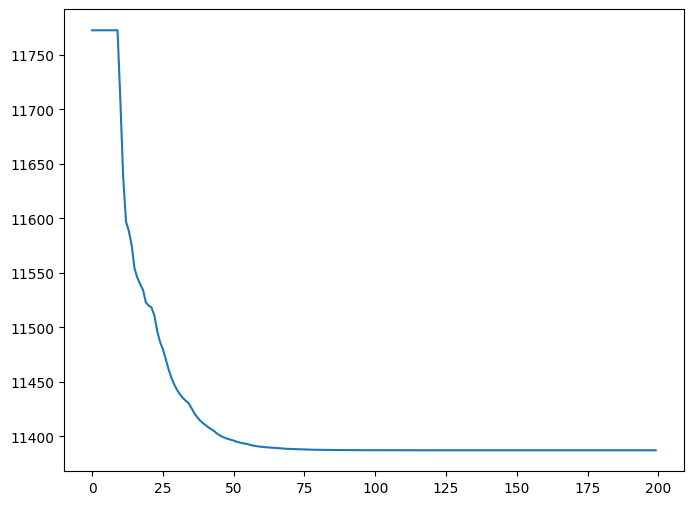

In [39]:
# Take all the etaps and censal sections------------------------------------------------------
etaps=list(gpd.GeoDataFrame(cons.variables.etaps).iterrows())
seccens=list(gpd.read_file(cons.files.output_full_ds_consum+".geojson").iterrows())
n_seccens=len(seccens)
n_etaps=len(etaps)

# Predicted values of consumption ------------------------------------------------------------
consums_districtes = np.array(predictions) # random for now to try
capacitat_recurs = gds_etaps["CAPACITAT AIGUA DIARIA(L)"].values

# Costs --------------------------------------------------------------------------------------
df = pd.read_csv(cons.files.output_cost_matrix,index_col=0)
costes = np.array(df)
# Hyper-parameter of the algorithm -----------------------------------------------------------
c1 = c2 = 0.1
w = 0.8

# Create particles 
n_particles = 20
X = np.random.rand(n_seccens,n_etaps-1, n_particles)
V = np.random.rand(n_seccens,n_etaps-1, n_particles) 

# Initialize data
pbest = X
litres_part = np.zeros((n_seccens,n_etaps,n_particles))
pbest_obj = np.zeros(n_particles)
for p in range(n_particles):
    litres_part[:,:,p] = transform_variables(n_seccens,n_etaps,consums_districtes, X[:,:,p], capacitat_recurs)
    pbest_obj[p] = f_v2(litres_part[:,:,p],costes)
gbest = pbest[:, :, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

converg = []
N_iter = 200
for i in range(N_iter):
    gbest, gbest_obj, X_ant , consum_matrix= update(n_seccens, n_etaps, costes, n_particles, w, c1, c2, consums_districtes, capacitat_recurs)
    converg.append(gbest_obj)
    if i == 0:
        print("Iteration {}: Best solution found at f({})={}".format(i, gbest, gbest_obj))
    else:
        print("Iteration {}: Best solution found at f()={}".format(i, gbest_obj))
litros_final = transform_variables(n_seccens,n_etaps,consums_districtes, np.copy(gbest), capacitat_recurs)
fig, ax = plt.subplots(figsize=(8,6))
iter = np.arange(N_iter)
ax.plot(iter, converg)
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))

In the figure, you can observe how the objective function decreases over the iterations of the PSO. Eventually, it converges to a final solution, which is nearly optimal. Reducing the objective function is equivalent to reducing the water distribution cost, as the function is calculated considering the energy cost of transporting water between different consumption points and water supply points, in our case, the WTSs.

### Mapa generation

In [43]:
gds_etaps=gpd.GeoDataFrame(cons.variables.etaps)
gds_consum=gpd.read_file(cons.files.output_full_ds_consum+".geojson")
cost_matrix_df=pd.read_csv(cons.files.output_cost_matrix, index_col=0)

noms_etaps = gds_etaps["NOM"].values
noms_consum = array_sec_cens
gds_etaps = gds_etaps.set_index("NOM")
gds_consum = gds_consum.set_index("Seccio Censal")
costs=[]
lines=[]
distancies=[]
codis_censals=[]
etaps=[]

for i, codi_censal in enumerate(litros_final):
    for j,etap in enumerate(codi_censal):
        etap = noms_etaps[j]
        codi_censal = noms_consum[i]
        codis_censals.append(codi_censal)
        etaps.append(etap)
        costs.append(litros_final[i][j])
        lines.append(LineString([loads(gds_consum["Centroid"][codi_censal]), gds_etaps["geometry"][etap]]))
        distancies.append(distancia(gds_etaps["geometry"][etap], loads(gds_consum["Centroid"][codi_censal])))

gds_water_paths=gpd.GeoDataFrame({
    "Litres": costs,
    "ETAP":etaps,
    "Seccio Censal": codis_censals,
    "Lenghts (m)": distancies,
    "geometry":lines
})

In [44]:
center_coord=(41.352543052311276, 2.049638990849189)
map=folium.Map(center_coord, zoom_control=3)

gds_water_paths_sjd=gds_water_paths[gds_water_paths["ETAP"]=="ETAP Sant Joan Despí"]
gds_water_paths_le=gds_water_paths[gds_water_paths["ETAP"]=="ETAP Les Estrelles"]
gds_water_paths_ll=gds_water_paths[gds_water_paths["ETAP"]=="ETAP La Llagosta"]
gds_water_paths_be=gds_water_paths[gds_water_paths["ETAP"]=="ETAP El Besòs"]

map=gds_consum.explore(m=map, color="Red", name="Consum")
map=gds_etaps.explore(m=map, color="Green", name="ETAP Sant Joan Despí")
map=gds_water_paths_sjd.explore(m=map, column="Litres", name="ETAP Sant Joan Despí")
map=gds_water_paths_le.explore(m=map, column="Litres", name="ETAP Les Estrelles")
map=gds_water_paths_ll.explore(m=map, column="Litres", name="La Llagosta")
map=gds_water_paths_be.explore(m=map, column="Litres", name="El Besòs")

folium.LayerControl().add_to(map)
folium.LatLngPopup().add_to(map)

map.save("mapa.html")

The map shows, layer by layer, the volumes calculated that each WTS must supply to the corresponding census section. The map is available in the file "mapa.html" saved in the Jupyter Notebook directory.

### CONCLUSIONS
The presented project demonstrates a proof of concept for a system to manage water distribution. It includes two blocks and a results visualization module. The two blocks are: a water demand predictor block and a water distribution optimizer block for census sections from the WTSs.

With this project, although still in the initial phase, we aim to demonstrate that such software can help the organization manage water more autonomously and optimally, minimizing the energy cost of water transportation. Additionally, this contributes to sustainability in the city of Barcelona. It also helps the city move towards future technologies, providing essential features for advancing towards becoming a Smart City.

### FUTURE WORK
By observing the performance of different parts of our system and keeping an open mind for future improvements, we believe this project can serve as a foundation for further development and can be used to increase the efficiency of the entire distribution system.

Regarding the predictor block, we ensured the selection of a system (DeepAR) that allows adding external variables besides consumption that might influence predictions. We have tested with daily temperature data in Barcelona and consider it important to add other features such as demographics or holidays.

For the distribution optimization block, we propose several improvements:

- Adding new distribution sources such as desalination plants or water reuse stations.
- Including in the cost calculation factors such as the water production cost at each WTS or the average efficiency of the pipelines/m, so the cost is better modeled.
- Accessing real paths (pipelines and reservoirs) to perform the PSO more accurately.

Finally, we are considering developing a new block that calculates real-time errors in predictions and distribution and corrects them in real-time.